# RADAR Reflectivity Download and Interpretation

In [1]:
import numpy as np

In [2]:
import os

# DWD proxy
os.environ["HTTP_PROXY"]  = "http://ofsquid.dwd.de:8080"
os.environ["HTTPS_PROXY"] = "http://ofsquid.dwd.de:8080"

# Optional but recommended
os.environ["http_proxy"]  = os.environ["HTTP_PROXY"]
os.environ["https_proxy"] = os.environ["HTTPS_PROXY"]

In [3]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin

base_url = "https://opendata.dwd.de/weather/radar/composite/hx/"
response = requests.get(base_url)
soup = BeautifulSoup(response.text, "html.parser")

# Filter for hd5 files
hd5_files = sorted([
    a.get("href") for a in soup.find_all("a")
    if "composite_hx" in a.get("href", "") and "-hd5" in a.get("href", "")
])

if hd5_files:
    latest_file = hd5_files[-1]
    download_url = urljoin(base_url, latest_file)
    print(f"Downloading: {latest_file}")

    r = requests.get(download_url)
    with open("radar.h5", "wb") as f:
        f.write(r.content)

    print("✅ Download complete: saved as 'radar.h5'")
else:
    print("⚠️ No suitable .hd5 files found in /hx/")


Downloading: composite_hx_LATEST-hd5
✅ Download complete: saved as 'radar.h5'


In [5]:
import h5py

with h5py.File("radar.h5", "r") as f:
    print("📁 Groups and datasets in radar.h5:")
    f.visit(lambda name: print(" -", name))
    
    # Try accessing a key dataset
    if "image1/image_data" in f:
        data = f["image1/image_data"][:]
        print("✅ Reflectivity data shape:", data.shape)
    else:
        print("⚠️ 'image1/image_data' not found — structure may differ.")


📁 Groups and datasets in radar.h5:
 - dataset1
 - dataset1/data1
 - dataset1/data1/data
 - dataset1/data1/what
 - dataset1/how
 - dataset1/what
 - how
 - how/POLARA
 - what
 - where
⚠️ 'image1/image_data' not found — structure may differ.


In [6]:
import h5py

with h5py.File("radar.h5", "r") as f:
    reflectivity = f["dataset1/data1/data"][:]
    print("Reflectivity shape:", reflectivity.shape)
    print("Min/Max values:", reflectivity.min(), reflectivity.max())


Reflectivity shape: (4800, 4400)
Min/Max values: 0 65535


In [5]:
with h5py.File("radar.h5", "r") as f:
    what = f["dataset1/data1/what"]
    gain = what.attrs.get("gain", 1.0)
    offset = what.attrs.get("offset", 0.0)
    undetect = what.attrs.get("undetect", None)

    print(f"Gain: {gain}, Offset: {offset}, Undetect value: {undetect}")

    reflectivity = reflectivity * gain + offset
    if undetect is not None:
        reflectivity[reflectivity == undetect] = np.nan

Gain: 0.002929821616590115, Offset: -64.00292982161659, Undetect value: 0.0


In [8]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Load and decode reflectivity field
with h5py.File("radar.h5", "r") as f:
    raw = f["dataset1/data1/data"][:]
    what = f["dataset1/data1/what"]
    gain = what.attrs.get("gain", 1.0)
    offset = what.attrs.get("offset", 0.0)
    undetect = what.attrs.get("undetect", 65535)  # default fallback

    print(f"Gain: {gain}, Offset: {offset}, Undetect: {undetect}")
    
    # Apply scaling and masking
    # Convert to float and apply gain/offset
    data = raw.astype(np.float32) * gain + offset
    
    # Mask missing values properly
    data[(raw == 65535) | (raw == 0) | (data < 0)] = np.nan

# Preview
print("Scaled data range:", np.nanmin(data), "to", np.nanmax(data))

Gain: 0.002929821616590115, Offset: -64.00292982161659, Undetect: 0.0
Scaled data range: 0.0019532144110598892 to 52.568812659270904


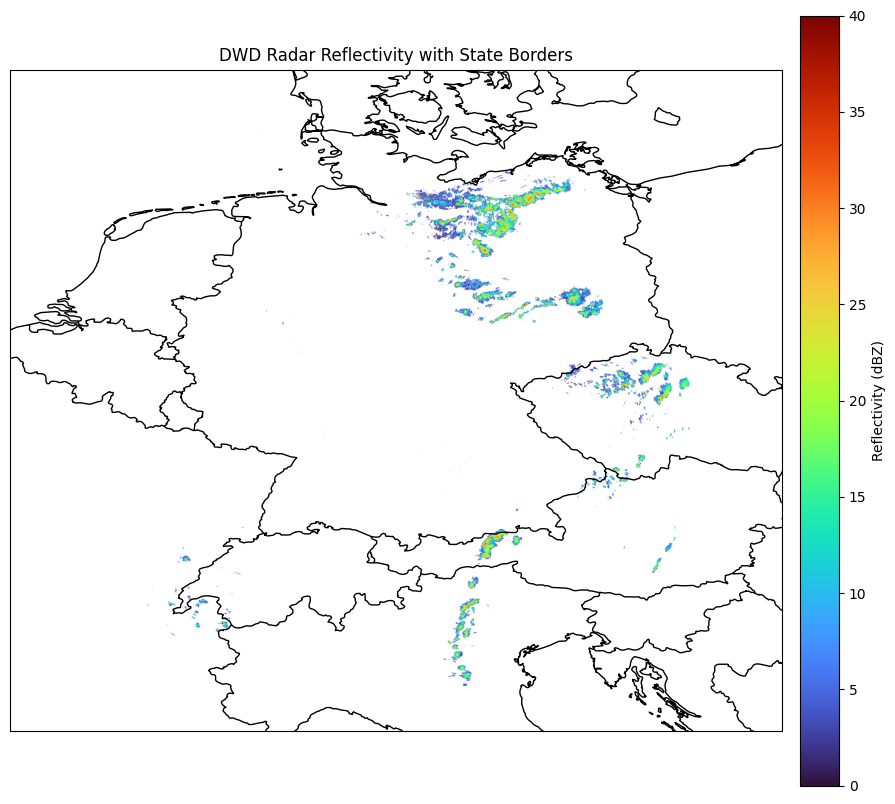

In [9]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import colormaps
import numpy as np

cmap = colormaps.get_cmap("turbo").copy()
cmap.set_bad(color='white')  # Set white background for NaNs

masked_data = np.ma.masked_invalid(data)

# Mask the data properly
masked_data = np.ma.masked_invalid(data)

# Define extent for Germany
extent = [3.0, 17.0, 44.0, 56.0]

# Plot
plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(extent, crs=ccrs.PlateCarree())

im = ax.imshow(masked_data, extent=extent, origin='lower',
               cmap=cmap, vmin=0, vmax=40, transform=ccrs.PlateCarree())

# Add features
cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label("Reflectivity (dBZ)")
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
ax.coastlines(resolution='10m')
ax.set_title("DWD Radar Reflectivity with State Borders")

# Save correctly
plt.savefig("radar_map_germany.png", dpi=150)
plt.show()


In [10]:
unique_values = np.unique(raw)
print("Unique raw values (sample):", unique_values[20:])
print("Min:", raw.min(), "Max:", raw.max())


Unique raw values (sample): [13915 13943 13953 ... 36939 39788 65535]
Min: 0 Max: 65535


In [14]:
from openai import OpenAI
from dotenv import load_dotenv
import os
import base64
from IPython.display import Markdown, display

# Load API key
load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# Encode the radar image as base64
image_path = "radar_map_germany.png"
with open(image_path, "rb") as image_file:
    base64_image = base64.b64encode(image_file.read()).decode("utf-8")

query='''
Please interpret this radar reflectivity image from Germany and 
neighboring countries. 
Describe precipitation areas, dBZ intensity ranges, and 
identify convective or stratiform structures.
'''

# Call GPT-4 Turbo with Vision
response = client.chat.completions.create(
    model="gpt-4-turbo",
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": query
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/png;base64,{base64_image}"
                    }
                }
            ]
        }
    ],
    max_tokens=800,
)

# Display as Markdown in notebook
interpretation = response.choices[0].message.content
display(Markdown(interpretation))

This radar reflectivity image shows precipitation distribution and intensity across Germany and parts of its neighboring countries, indicated by different colors reflecting different reflectivity values measured in dBZ (decibels of Z). Here's a detailed analysis:

### Precipitation Areas:
1. **Northern Germany (Northwest regions and extending into the Baltic Sea)**: This area shows patches of precipitation, primarily in the blue to green spectrum, indicating light to moderate rainfall.
2. **Eastern Germany (around the borders with Poland)**: Here, we observe scattered areas of precipitation, mainly in the green color range, suggesting moderate rainfall.
3. **Southern Germany (close to the borders with Austria and Switzerland)**: Several smaller patches of precipitation can be seen, largely in lighter shades of green, which indicate moderate rainfall.

### dBZ Intensity Ranges:
- **Light blue (around 5 to 15 dBZ)**: Represents areas of light precipitation, mostly consisting of light rain or drizzle.
- **Green (around 15 to 25 dBZ)**: Represents moderate rainfall.
- **Yellow to orange areas (25 to 35 dBZ)**: These are less common in this image, but would correspond to heavier rainfall. Here they appear in small isolated patches within northern Germany, suggests that these could be convective cells (possibly showers or thunderstorms).

### Convective or Stratiform Structures:
- **Stratiform Rainfall:** The majority of the precipitation patterns, especially the widespread areas with uniform green shades in the northern and southwestern parts, suggest stratiform precipitation structures. These are typically smooth and consistent patterns associated with frontal systems or broad-scale upward motions that produce persistent and uniform rainfall.
- **Convective Cells:** The isolated, smaller patches with higher dBZ values, seen as blotches within northern areas and along the southern border regions, likely indicate convective activity. These structures are often more scattered and less uniform, hinting at localized showers or thunderstorms, likely driven by local atmospheric instabilities.

The overall setup on the radar image suggests a weather scenario with mixed precipitation types, predominantly light to moderate rainfall across the regions, with some potential localized convective activity causing sporadic heavier showers or thunderstorms. This interpretation could provide insights into weather forecasts, planning for activities requiring weather considerations, or scientific analysis of the atmospheric conditions prevailing at the time.

In [15]:
print(interpretation)

This radar reflectivity image shows precipitation distribution and intensity across Germany and parts of its neighboring countries, indicated by different colors reflecting different reflectivity values measured in dBZ (decibels of Z). Here's a detailed analysis:

### Precipitation Areas:
1. **Northern Germany (Northwest regions and extending into the Baltic Sea)**: This area shows patches of precipitation, primarily in the blue to green spectrum, indicating light to moderate rainfall.
2. **Eastern Germany (around the borders with Poland)**: Here, we observe scattered areas of precipitation, mainly in the green color range, suggesting moderate rainfall.
3. **Southern Germany (close to the borders with Austria and Switzerland)**: Several smaller patches of precipitation can be seen, largely in lighter shades of green, which indicate moderate rainfall.

### dBZ Intensity Ranges:
- **Light blue (around 5 to 15 dBZ)**: Represents areas of light precipitation, mostly consisting of light rai